<a href="https://colab.research.google.com/github/klsharma22/TensorflowCertifcationCourse/blob/main/Milestone%20Projects/09_milestone_project_2_Skim_Lit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating is avaliable here: [PubMed 200k RCT](https://arxiv.org/abs/1710.06071)

Reading through the paper above, we see that the model architecture that they use to achieve their best results is availbale here: [Neural Networks for Joint Sentence Classification](https://arxiv.org/abs/1612.05251)

## Get data

Since we are replicating the model from the above paper, let's use their data.

[Dataset](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 14.79 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [2]:
# Check what files are in the PubMed20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
# Start our experiments using the 20k dataset with numbers replaced by '@' sign
# data_dir = '/Users/klsharma22/Desktop/TensorflowCertifcationCourse/Milestone Projects/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [4]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, it's time to get one with it.

In [5]:
# Create a function to read the lines of the document
def get_lines(filename):
    '''
    Reads filename and returns the lines of text as a list.

    Args:
        filename (str): Path of filename

    Returns:
        A list of string with one string per line from the target filename
    '''

    with open(filename, 'r') as f:
        return f.readlines()

In [6]:
# Let's read in the training lines
train_lines = get_lines(filenames[2])
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look

Representation of the data:

```
[{'line_number': 0,
    'target': 'BACKGROUND',
    'text': 'xyz',
    'total_lines': 11}]
```

In [7]:
def preprocess_text_with_line_numbers(filename):
    '''
    Returns a list of dictionary of abstract line data.

    Takes in filename, reads it contents and sorts through each line, extracting things like the target label, the text of the sentence, number of snetences and what sentence number line is.
    '''
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines: # if the line is the id number
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace(): # if it is the new line
            abstract_line_split = abstract_lines.splitlines()

            for line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split('\t')
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower()
                line_data['line_number'] = line_number
                line_data['total_lines'] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)

        else: # if it is the text
            abstract_lines += line

    return abstract_samples

In [8]:
train_samples = preprocess_text_with_line_numbers(filenames[2])
val_samples = preprocess_text_with_line_numbers(filenames[1])
test_samples = preprocess_text_with_line_numbers(filenames[0])

len(train_samples), len(val_samples), len(test_samples)

(180040, 30135, 30212)

In [9]:
# Check the first abstract
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that we have our data in the form of dictionary, let's create a dataframe

In [10]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [11]:
# Distribution of labels
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

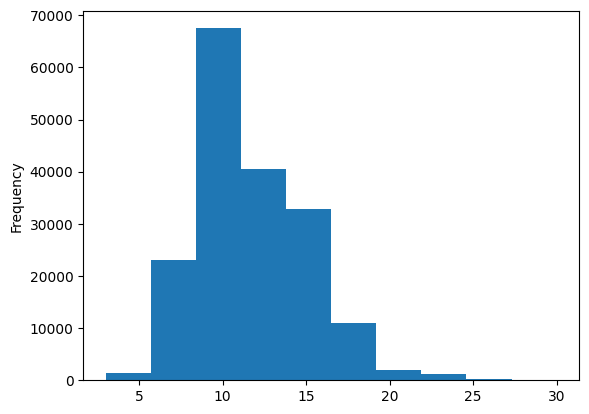

In [12]:
# Let's check length of different lines
train_df['total_lines'].plot.hist()

### Get a lists of sentences

In [13]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30135, 30212)

## Make numeric labels

In [14]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse= False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

len(train_labels_one_hot), len(val_labels_one_hot), len(test_labels_one_hot)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(180040, 30135, 30212)

## Label encode labels

In [15]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [16]:
# get class names and number of classes from LabelEncoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Experiments

### Model 0: Getting a baseling

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X= train_sentences,
            y= train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [18]:
# Evaluate baseline model on validation dataset
model_0.score(X= val_sentences,
              y= val_labels_encoded)

0.716674962667994

In [19]:
# Make prediction using baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([2, 2, 2, ..., 4, 4, 4])

#### Download helper function script for evaluation

In [20]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-18 05:26:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-18 05:26:07 (85.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [21]:
from helper_functions import calculate_results

In [22]:
# Calculate baseline results
baseline_results = calculate_results(y_true= val_labels_encoded,
                                     y_pred= baseline_preds)
baseline_results

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

In [23]:
import tensorflow as tf

## Preparing our data for deep sequence models

Before we start building deep model, we've got tocreate vectorization and embedding layers

In [24]:
import numpy as np
from tensorflow.keras import layers

In [25]:
# how long is ech sentences on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_len = np.mean(sent_lens)
avg_sentence_len

26.338269273494777

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <BarContainer object of 30 artists>)

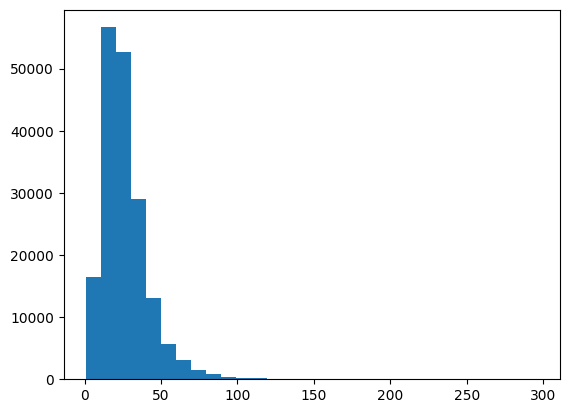

In [26]:
# What is the distribution of the sentences
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins= 30)

In [27]:
# How longof a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [28]:
# maximum sequence length
max(sent_lens)

296

### Create text vectorizzer layer

We want to make a layer which converts text data into vectors

In [29]:
# Creating text vectorizer
max_vocab = 68000
text_vectorizer = layers.TextVectorization(max_tokens= max_vocab,
                                           output_sequence_length= output_seq_len)

In [30]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [31]:
# Test out text vectorizer on random sentences

import random
target_senteces = random.choice(train_sentences)
print(f"Text: {target_senteces}")
print(f"Length of Text: {len(target_senteces.split())}")
print(f"Vectorized: {text_vectorizer(target_senteces)}")

Text: facial lines outcomes ( flo-@ ) questionnaire , self-perception of age ( spa ) , and subject global assessment of change in cfl ( sga-cfl ) were pro measures administered in @ phase @ , double-blind placebo-controlled trials for the treatment of cfl alone or cfl/glabellar lines ( gl ) .
Length of Text: 51
Vectorized: [ 1704  3598    75 26525   325 15450     4   103  4929     3  1567   647
   250     4   133     5 10424 34462     9  2688   213   336     5   209
   236   329   233    11     2    19     4 10424   271    16 61742  3598
  2013     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [32]:
# How many words in our training vocab
rct_20k_vocab = text_vectorizer.get_vocabulary()

print(f"Number of words in vocab: {len(rct_20k_vocab)}")
print(f"Most common words: {rct_20k_vocab[:5]}")
print(f"Least common words: {rct_20k_vocab[-5:]}")

Number of words in vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [33]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create an embedding layer

In [34]:
embedding = layers.Embedding(input_dim= len(rct_20k_vocab),
                             output_dim= 128,
                             mask_zero= True, # use masking to handle variable sequence length
                             name= 'token_embedding'
                             )

In [35]:
random_sentence = random.choice(train_sentences)
print(f"Text: {random_sentence}")
print(f"Embed: {embedding(text_vectorizer([random_sentence])).shape}")

Text: the checklist was viewed by two service users who gave suggestions for improvements .
Embed: (1, 55, 128)


## Creating dataset

We're going to setup our data to run as fast as possible with tf.data API

In [36]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [37]:
# Take the tensor_slice dataset and turn them into prefetch dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: CNN 1D

In [38]:
inputs = layers.Input(shape= (1, ), dtype= 'string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64, 5, activation= 'relu', padding='same', name= 'cnn_1d_layer')(x)
x = layers.GlobalAveragePooling1D(name= 'global_avg_pool_layer')(x)
outputs = layers.Dense(num_classes, activation= 'softmax', name= 'output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(),
                metrics= ['accuracy'])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 cnn_1d_layer (Conv1D)       (None, 55, 64)            41024     
                                                                 
 global_avg_pool_layer (Glo  (None, 64)                0         
 balAveragePooling1D)                                            
                                                             

In [39]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch= int(0.1 * len(train_dataset)),
                              epochs= 5,
                              validation_data= val_dataset,
                              validation_steps= int(0.1 * len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 8s 9ms/step - loss: 0.9204 - accuracy: 0.6388 - val_loss: 0.6840 - val_accuracy: 0.7307
Epoch 2/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6635 - accuracy: 0.7524 - val_loss: 0.6390 - val_accuracy: 0.7616
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6258 - accuracy: 0.7699 - val_loss: 0.5995 - val_accuracy: 0.7779
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5958 - accuracy: 0.7865 - val_loss: 0.5746 - val_accuracy: 0.7836
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5940 - accuracy: 0.7898 - val_loss: 0.5552 - val_accuracy: 0.7916


In [40]:
model_1.evaluate(val_dataset)

942/942 [==============================] - 3s 3ms/step - loss: 0.5769 - accuracy: 0.7924


[0.5768715143203735, 0.792367696762085]

In [41]:
model_1_pred = tf.argmax(model_1.predict(val_dataset), axis= 1).numpy()
model_1_pred

942/942 [==============================] - 2s 2ms/step


array([2, 2, 2, ..., 4, 4, 1])

In [42]:
# Calculate results
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_pred)
model_1_results

{'accuracy': 79.23676787788287,
 'precision': 0.7911303586127434,
 'recall': 0.7923676787788286,
 'f1': 0.7888905100625141}

In [43]:
baseline_results

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

In [44]:
import tensorflow_hub as hub

In [45]:
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                        trainable= False,
                                        name= 'USE_layer')

### Model 2: Transfer Learning

In [46]:
inputs = layers.Input(shape= [], dtype= 'string', name= 'input_layer')
x = sentence_encoder_layer(inputs)
x = layers.Dense(128, activation= 'relu')(x)
outputs = layers.Dense(num_classes, activation= 'softmax', name= 'output_layer')(x)

model_2 = tf.keras.Model(inputs= inputs, outputs= outputs, name= 'model_2_USE')

model_2.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['accuracy'])

In [47]:
model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 USE_layer (KerasLayer)      (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [48]:
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch= int(0.1 * len(train_dataset)),
                              epochs= 5,
                              validation_data= val_dataset,
                              validation_steps= int(0.1 * len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 12s 13ms/step - loss: 0.9169 - accuracy: 0.6490 - val_loss: 0.8328 - val_accuracy: 0.6828
Epoch 2/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7691 - accuracy: 0.7011 - val_loss: 0.7796 - val_accuracy: 0.6971
Epoch 3/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7530 - accuracy: 0.7106 - val_loss: 0.7577 - val_accuracy: 0.7031
Epoch 4/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7199 - accuracy: 0.7246 - val_loss: 0.7302 - val_accuracy: 0.7214
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7280 - accuracy: 0.7198 - val_loss: 0.7173 - val_accuracy: 0.7231


In [49]:

model_2_pred = tf.argmax(model_2.predict(val_dataset), axis= 1)
model_2_pred

942/942 [==============================] - 9s 9ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 3, 2, ..., 4, 4, 2])>

In [50]:
model_2_results = calculate_results(val_labels_encoded,
                                    model_2_pred)
model_2_results

{'accuracy': 72.81234444997511,
 'precision': 0.7242221264043358,
 'recall': 0.7281234444997511,
 'f1': 0.7227688536826511}

In [51]:
baseline_results, model_1_results

({'accuracy': 71.6674962667994,
  'precision': 0.7124322482375202,
  'recall': 0.716674962667994,
  'f1': 0.6925101703856846},
 {'accuracy': 79.23676787788287,
  'precision': 0.7911303586127434,
  'recall': 0.7923676787788286,
  'f1': 0.7888905100625141})

### Model 3: CNN 1D with character embeddings

The paper we are replicating uses the combination of character and token embedding.

We've only used token embedding in the previous experiments. In order to replicate we need to do the similar steps.

#### Creating Character level tokenizer

In [52]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [183]:
# Make a function which splits the sentence
def split_chars(text):
  return " ".join(list(text.strip().lower()))

In [184]:
# Split data into character level
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [55]:
# What is the average chartacter length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <BarContainer object of 20 artists>)

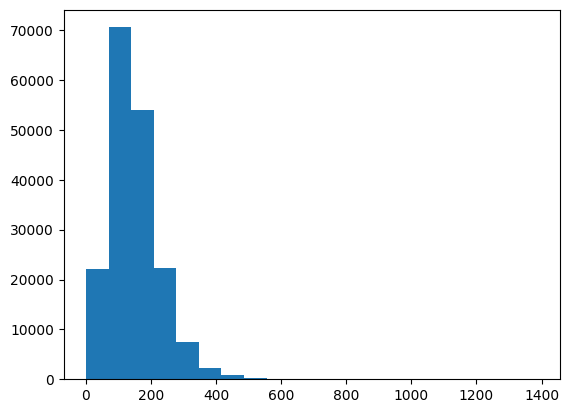

In [56]:
# Check the distribution of the character level
plt.hist(char_lens, bins= 20)

In [57]:
# Find what character lenght covers 95% of the training data
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [58]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [59]:
# Create char level tokenizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # 2 for space and OOV
char_vectorizer = layers.TextVectorization(max_tokens= NUM_CHAR_TOKENS,
                                           output_sequence_length= output_seq_char_len,
                                           name= 'character_tokenizer')

In [60]:
# Adapt character vectorizer
char_vectorizer.adapt(train_chars)

In [61]:
# Check for vocbulary
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab), char_vocab[:5], char_vocab[-5:]

(28, ['', '[UNK]', 'e', 't', 'i'], ['k', 'x', 'z', 'q', 'j'])

In [62]:
# Test character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Character-level sentence: {random_train_chars}")
print(f"Length of sentence: {len(random_train_chars.split())}")
print(f"Vectorized sentence: {len(char_vectorizer(random_train_chars))}")

Character-level sentence: w h i l e   t h e r e   w e r e   n o   b e t w e e n - g r o u p   d i f f e r e n c e s   i n   i m p r o v e m e n t   f o r   a n y   o f   t h e   s y m p t o m s   ,   t h e   l e n g t h   o f   h o s p i t a l i z a t i o n   w a s   s i g n i f i c a n t l y   l o w e r   i n   g r o u p   a   (   @   @   d a y s   )   t h a n   i n   g r o u p   b   (   @   @   d a y s   )   (   p   =   @   )   .
Length of sentence: 162
Vectorized sentence: 290


#### Creating a character level embedding

In [63]:
# Create char embedding layer
char_embedding = layers.Embedding(input_dim= len(char_vocab),
                                  output_dim= 25,
                                  mask_zero= True,
                                  name= 'character_embedding_layer')

In [64]:
# Test out character level embedding layer
print(f"Sentence: {random_train_chars}")
print(f"Lenght of embedded: {char_embedding(char_vectorizer(random_train_chars)).shape}")

Sentence: w h i l e   t h e r e   w e r e   n o   b e t w e e n - g r o u p   d i f f e r e n c e s   i n   i m p r o v e m e n t   f o r   a n y   o f   t h e   s y m p t o m s   ,   t h e   l e n g t h   o f   h o s p i t a l i z a t i o n   w a s   s i g n i f i c a n t l y   l o w e r   i n   g r o u p   a   (   @   @   d a y s   )   t h a n   i n   g r o u p   b   (   @   @   d a y s   )   (   p   =   @   )   .
Lenght of embedded: (290, 25)


In [65]:
# Create model
inputs = layers.Input(shape= (1, ), dtype= 'string', name= 'input_layer')
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(64, 5, name= 'cnn_1D_layer')(x)
x = layers.GlobalMaxPool1D(name= 'global_max_pool_layer')(x)
outputs = layers.Dense(len(class_names), activation= 'softmax', name= 'output_layer')(x)

model_3 = tf.keras.Model(inputs, outputs, name= 'model_3_cnn1D_char_embedding')

model_3.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['accuracy'])

In [66]:
model_3.summary()

Model: "model_3_cnn1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 character_tokenizer (TextV  (None, 290)               0         
 ectorization)                                                   
                                                                 
 character_embedding_layer   (None, 290, 25)           700       
 (Embedding)                                                     
                                                                 
 cnn_1D_layer (Conv1D)       (None, 286, 64)           8064      
                                                                 
 global_max_pool_layer (Glo  (None, 64)                0         
 balMaxPooling1D)                                                
                                      

In [67]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [68]:
# Fit the model
model_3_history = model_3.fit(train_char_dataset,
                              epochs= 5,
                              steps_per_epoch= int(0.1 * len(train_char_dataset)),
                              validation_data = val_char_dataset,
                              validation_steps= int(0.1 * len(val_char_dataset)))

Epoch 1/5
94/94 [==============================] - 3s 14ms/step - loss: 1.4779 - accuracy: 0.3949 - val_loss: 1.4103 - val_accuracy: 0.4757
Epoch 2/5
94/94 [==============================] - 1s 9ms/step - loss: 1.3734 - accuracy: 0.4601 - val_loss: 1.3309 - val_accuracy: 0.4668
Epoch 3/5
94/94 [==============================] - 1s 9ms/step - loss: 1.2926 - accuracy: 0.4734 - val_loss: 1.2185 - val_accuracy: 0.5199
Epoch 4/5
94/94 [==============================] - 1s 9ms/step - loss: 1.1903 - accuracy: 0.5263 - val_loss: 1.1209 - val_accuracy: 0.5545
Epoch 5/5
94/94 [==============================] - 1s 9ms/step - loss: 1.1194 - accuracy: 0.5539 - val_loss: 1.0679 - val_accuracy: 0.5678


In [69]:
# Make predictions with our character embedding model
model_3_pred = tf.argmax(model_3.predict(val_char_dataset), axis= 1)
model_3_pred

942/942 [==============================] - 3s 3ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([2, 2, 2, ..., 4, 4, 1])>

In [70]:
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_pred)
model_3_results

{'accuracy': 55.32105525136885,
 'precision': 0.5671706839546795,
 'recall': 0.5532105525136884,
 'f1': 0.5071516755943412}

#### Model 4: Combining pretrained token embeddings with character embeddings

1. Create a token level embedding
2. Create a character level embedding
3. Combine both of the model with a concatenate layer
4. Build a series of output layers on top of 3 similar to the figure in the paper
5. Construct a model which takes token and character level embeddings as inputs and produce a classification as an output

In [71]:
# 1. Setup Token level Embedding
token_inputs = layers.Input(shape= [], dtype= 'string', name= 'token_input_layer')
token_embeddings = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense(128, activation= 'relu', name= 'token_output_layer')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name= 'token_model')

# 2. Setup Character level embedding
char_inputs = layers.Input(shape= (1, ), dtype= 'string', name= 'char_input_layer')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_outputs = layers.Bidirectional(layers.LSTM(25), name= 'char_output_layer')(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_outputs, name= 'char_model')

# 3. Concatenate token and character embeddings
token_char_concatenate = layers.Concatenate(name= 'token_char_contatenate_layer')([token_model.output, char_model.output])

# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concatenate)
combined_dense = layers.Dense(128, activation= 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
final_output = layers.Dense(len(class_names), activation= 'softmax', name= 'final_output_layer')(final_dropout)

# 5. Construct the final model
model_4 = tf.keras.Model(inputs= [token_model.input, char_model.input], outputs= final_output, name= 'model_4_token_char_embeddings')

In [72]:
# Get a summary
model_4.summary()

Model: "model_4_token_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input_layer (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 token_input_layer (InputLa  [(None,)]                    0         []                            
 yer)                                                                                             
                                                                                                  
 character_tokenizer (TextV  (None, 290)                  0         ['char_input_layer[0][0]']    
 ectorization)                                                        

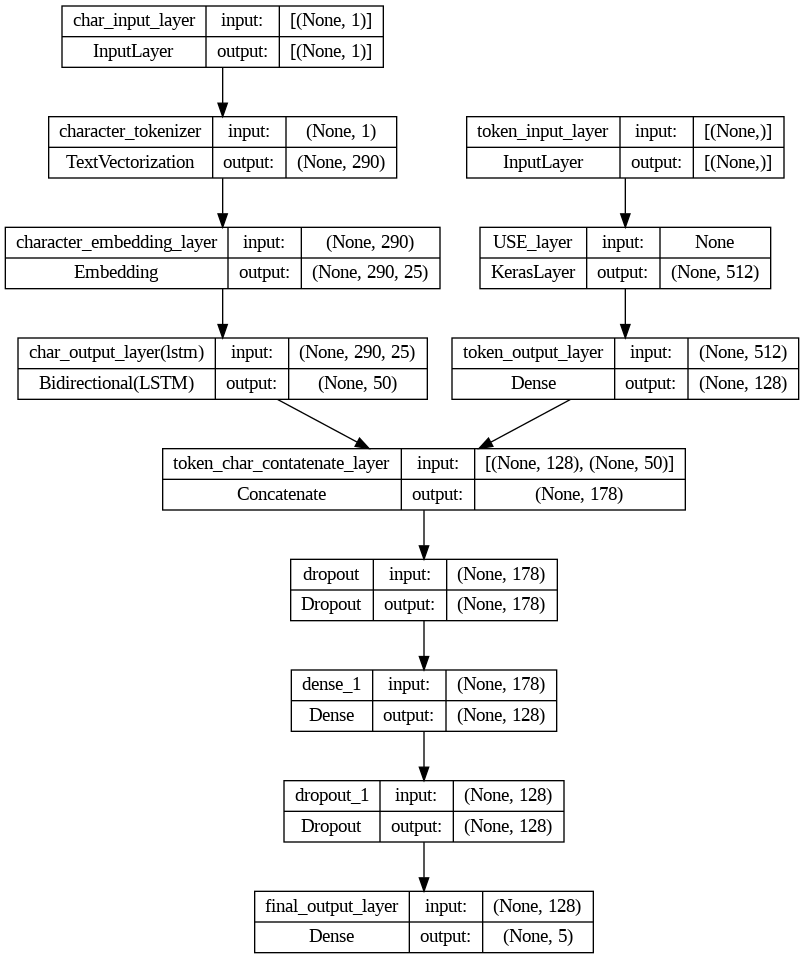

In [73]:
from keras.utils import plot_model
plot_model(model_4, show_shapes= True)

In [74]:
# Compile the model
model_4.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['accuracy'],
                run_eagerly= True)

In [75]:
# Creating dataset for our model to train
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip(train_char_token_data, train_char_token_labels).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip(val_char_token_data, val_char_token_labels).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip(test_char_token_data, test_char_token_labels).batch(32).prefetch(tf.data.AUTOTUNE)

In [76]:
train_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [77]:
history_model_4 = model_4.fit(train_char_token_dataset,
             epochs= 5,
             steps_per_epoch= int(0.1 * len(train_char_token_dataset)),
             validation_data= val_char_token_dataset,
             validation_steps= int(0.1 * len(val_char_token_dataset)))

Epoch 1/5


562/562 [==============================] - 99s 167ms/step - loss: 0.9858 - accuracy: 0.6084 - val_loss: 0.8171 - val_accuracy: 0.6862
Epoch 2/5
562/562 [==============================] - 94s 167ms/step - loss: 0.8007 - accuracy: 0.6922 - val_loss: 0.7563 - val_accuracy: 0.7051
Epoch 3/5
562/562 [==============================] - 83s 147ms/step - loss: 0.7771 - accuracy: 0.7080 - val_loss: 0.7164 - val_accuracy: 0.7244
Epoch 4/5
562/562 [==============================] - 97s 173ms/step - loss: 0.7409 - accuracy: 0.7179 - val_loss: 0.6932 - val_accuracy: 0.7367
Epoch 5/5
562/562 [==============================] - 92s 163ms/step - loss: 0.7536 - accuracy: 0.7150 - val_loss: 0.6843 - val_accuracy: 0.7324


In [78]:
model_4_pred = tf.argmax(model_4.predict(val_char_token_dataset), axis= 1)
model_4_pred

942/942 [==============================] - 65s 69ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([2, 2, 2, ..., 4, 4, 1])>

In [79]:
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_pred)
model_4_results

{'accuracy': 73.75477020076323,
 'precision': 0.7342728180545983,
 'recall': 0.7375477020076323,
 'f1': 0.7315039517418926}

In [80]:
baseline_results

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

#### Model 5: Transfer Learning with pretrained token embedding, character embedding and positional embedding

In [81]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> Note: Any engineered features used to train the model need to be available on testing. In our case, line numbers and total line numbers.

##### Create Positional Embeddings

<Axes: ylabel='Frequency'>

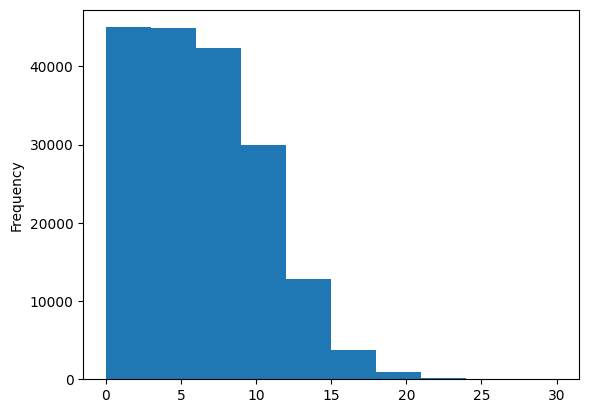

In [82]:
# Distribution of line numbers
train_df['line_number'].plot.hist()

In [83]:
# Check the values of each line number
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [84]:
# Use TensorFlow to create a one-hot encoded tensors of our 'line_number' column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth= 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth= 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth= 15)
train_line_numbers_one_hot.shape, val_line_numbers_one_hot.shape, test_line_numbers_one_hot.shape

(TensorShape([180040, 15]), TensorShape([30135, 15]), TensorShape([30212, 15]))

Do the same exact thing for the total line number in train_df

<Axes: ylabel='Frequency'>

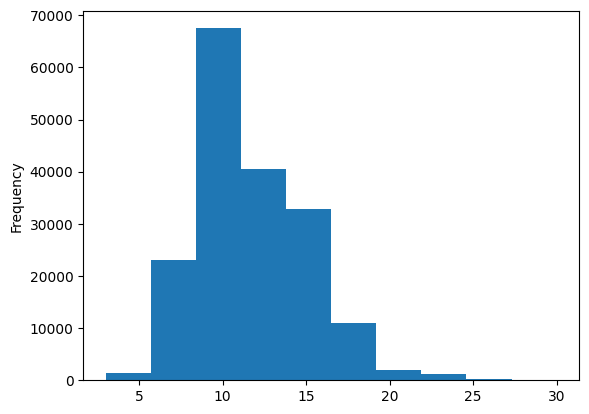

In [85]:
# Distribution of total_lines in train_df
train_df['total_lines'].plot.hist()

In [86]:
# Checking value counts of total lines
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [87]:
# CCheck the percentile
np.percentile(train_df['total_lines'], 98)

20.0

In [88]:
# Use TensorFlow to create one-hot encoding on total_lines feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth= 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth= 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth= 20)
train_total_lines_one_hot.shape, val_total_lines_one_hot.shape, test_total_lines_one_hot.shape

(TensorShape([180040, 20]), TensorShape([30135, 20]), TensorShape([30212, 20]))

##### Building a tribrid embedding model

1. Create a token level model
2. Create a character level model
3. Create a line number model
4. Create a total lines model
5. Combine the outputs of 1 and 2 of concatenate
6. Combine the output of 3, 4 and 5 using concatenate
7. Create an output layers to accept all of the above three inputs and give the output label possibilities
8. Combine the inputs of 1, 2, 3, 4 and outputs into a model

In [89]:
# 1. Token inputs
token_inputs = layers.Input(shape= [], dtype= 'string', name= 'token_input_layer')
token_embeddings = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense(128, activation= 'relu', name= 'token_output_layer')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name= 'token_model')

# 2. Character inputs
char_inputs = layers.Input(shape= (1, ), dtype= 'string', name= 'char_input_layer')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_outputs = layers.Bidirectional(layers.LSTM(25), name= 'char_output_bi_lstm_layer')(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_outputs, name= 'char_model')

# 3. Line numbers inputs
line_num_inputs = layers.Input(shape= (15, ), name= 'line_num_input_layer')
line_num_outputs = layers.Dense(32, activation= 'relu', name= 'line_num_output_layer')(line_num_inputs)
line_num_model = tf.keras.Model(line_num_inputs, line_num_outputs, name= 'line_num_model')

# 4. Total line numbers inputs
tot_line_inputs = layers.Input(shape= (20, ), name= 'total_lines_input_layers')
tot_line_outputs = layers.Dense(32, activation= 'relu', name= 'total_lines_output_layers')(tot_line_inputs)
tot_line_model = tf.keras.Model(tot_line_inputs, tot_line_outputs, name= 'total_lines_model')

# 5. Combine token and char embeddings into one
token_char_embeddings = layers.Concatenate(name= 'token_char_embeddings')([token_model.output, char_model.output])
x = layers.Dense(256, activation= 'relu')(token_char_embeddings)
x = layers.Dropout(0.5)(x)

# 6. Combine positional embeddings with token and char combined embeddings
final_embeddings = layers.Concatenate(name= 'final_embeddings')([x, line_num_model.output, tot_line_model.output])

# 7. Create output layer
final_output_layer = layers.Dense(len(class_names), activation= 'softmax', name= 'final_output_layer')(final_embeddings)

# 8. Create Model
model_5 = tf.keras.Model(inputs= [token_model.input, char_model.input, line_num_model.input, tot_line_model.input],
                         outputs= final_output_layer, name= 'token_char_positional_model')

model_5.summary()

Model: "token_char_positional_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input_layer (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 token_input_layer (InputLa  [(None,)]                    0         []                            
 yer)                                                                                             
                                                                                                  
 character_tokenizer (TextV  (None, 290)                  0         ['char_input_layer[0][0]']    
 ectorization)                                                          

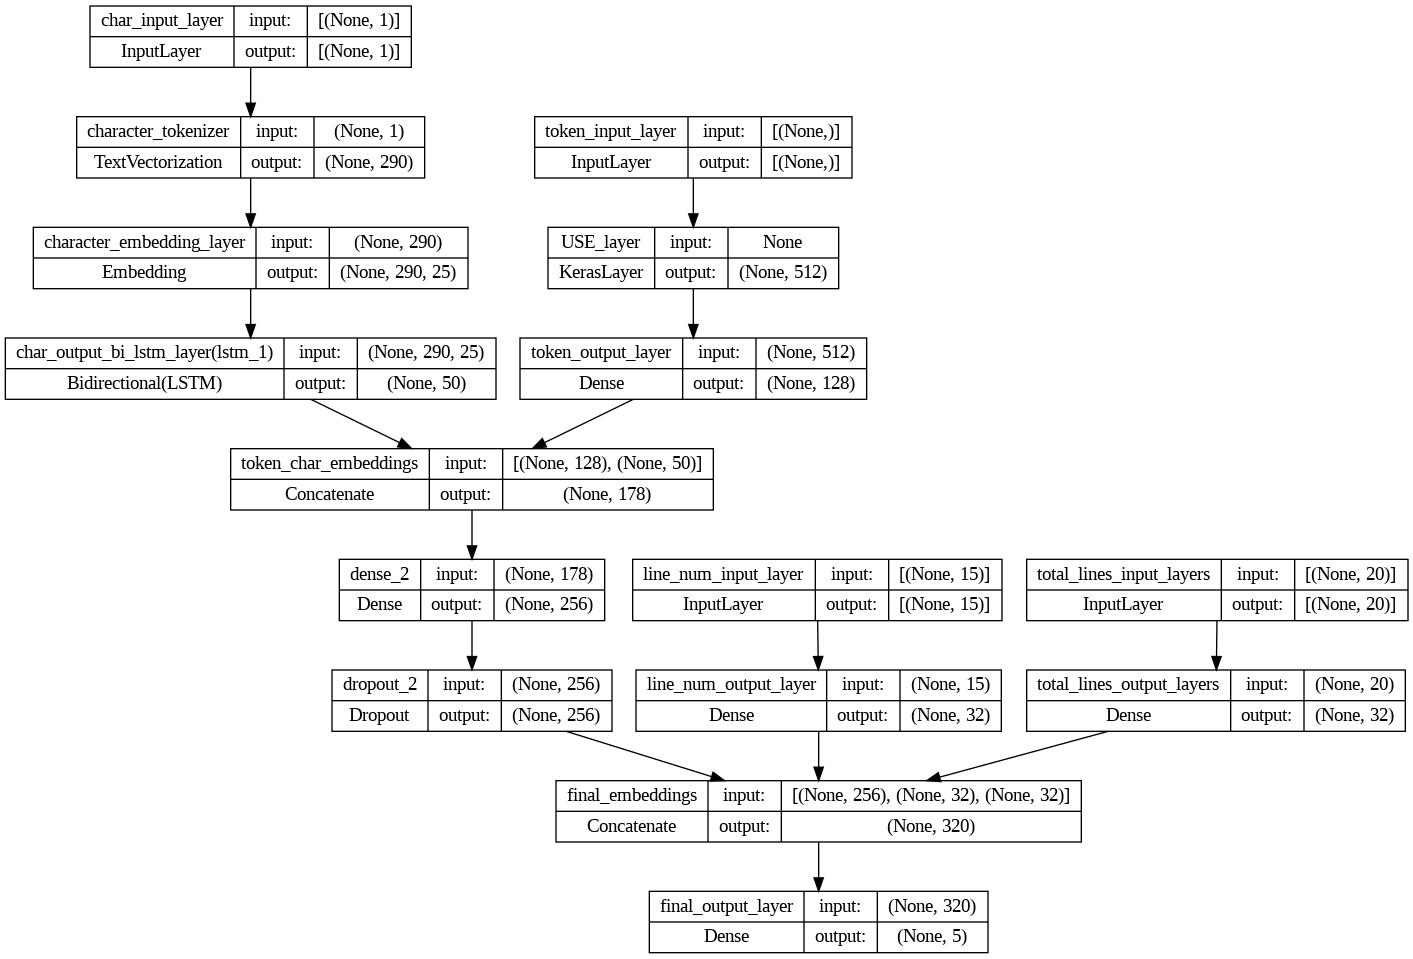

In [90]:
plot_model(model_5, show_shapes= True)

What is label smoothing?
> If our model is too confident upon one class then it might oversee the other classes. So, label smoothing distributes the output probability to other classes just to make the model consider other models

In [91]:
# Compile the model
model_5.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing= 0.2), # helps to prevent overfitting
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['accuracy'])

In [92]:
# Create the dataset using tf.data API
train_all_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars, train_line_numbers_one_hot, train_total_lines_one_hot))
train_all_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_all_dataset = tf.data.Dataset.zip(train_all_data, train_all_labels).batch(32).prefetch(tf.data.AUTOTUNE)
val_all_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars, val_line_numbers_one_hot, val_total_lines_one_hot))
val_all_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_all_dataset = tf.data.Dataset.zip(val_all_data, val_all_labels).batch(32).prefetch(tf.data.AUTOTUNE)
test_all_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars, test_line_numbers_one_hot, test_total_lines_one_hot))
test_all_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_all_dataset = tf.data.Dataset.zip(test_all_data, test_all_labels).batch(32).prefetch(tf.data.AUTOTUNE)

train_all_dataset, val_all_dataset, test_all_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [93]:
model_5.fit(train_all_dataset,
            epochs= 5,
            steps_per_epoch= int(0.1 * len(train_all_dataset)),
            validation_data= val_all_dataset,
            validation_steps= int(0.1 * len(val_all_dataset)))

Epoch 1/5
562/562 [==============================] - 33s 42ms/step - loss: 1.0909 - accuracy: 0.7283 - val_loss: 0.9993 - val_accuracy: 0.7902
Epoch 2/5
562/562 [==============================] - 20s 35ms/step - loss: 0.9647 - accuracy: 0.8166 - val_loss: 0.9646 - val_accuracy: 0.8198
Epoch 3/5
562/562 [==============================] - 18s 33ms/step - loss: 0.9475 - accuracy: 0.8242 - val_loss: 0.9466 - val_accuracy: 0.8318
Epoch 4/5
562/562 [==============================] - 21s 37ms/step - loss: 0.9381 - accuracy: 0.8367 - val_loss: 0.9347 - val_accuracy: 0.8341
Epoch 5/5
562/562 [==============================] - 19s 34ms/step - loss: 0.9343 - accuracy: 0.8367 - val_loss: 0.9306 - val_accuracy: 0.8401


In [94]:
model_5_pred = tf.argmax(model_5.predict(val_all_dataset), axis= 1)
model_5_pred

942/942 [==============================] - 16s 14ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [95]:
model_5_results = calculate_results(val_labels_encoded,
                                    model_5_pred)
model_5_results

{'accuracy': 83.7862950058072,
 'precision': 0.8398222878210322,
 'recall': 0.837862950058072,
 'f1': 0.8339697258097287}

### Comparing Model Performance

In [96]:
model_all_results = pd.DataFrame([baseline_results, model_1_results, model_2_results, model_3_results, model_4_results, model_5_results], index= ['baseline', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5'])
model_all_results['accuracy'] = model_all_results['accuracy'] / 100
model_all_results.transpose()

,baseline,model_1,model_2,model_3,model_4,model_5
accuracy,0.716675,0.792368,0.728123,0.553211,0.737548,0.837863
precision,0.712432,0.791130,0.724222,0.567171,0.734273,0.839822
recall,0.716675,0.792368,0.728123,0.553211,0.737548,0.837863
f1,0.692510,0.788891,0.722769,0.507152,0.731504,0.833970


<Axes: >

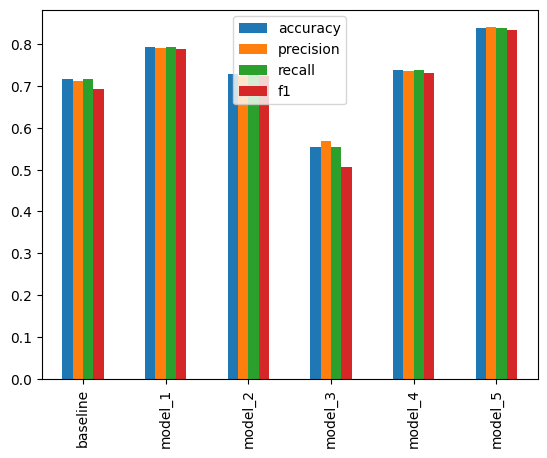

In [97]:
model_all_results.plot.bar().legend(bbox_to_anchor= (1.0, 1.0))

<Axes: >

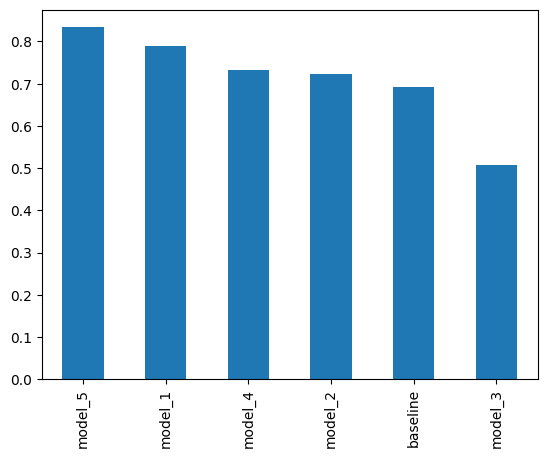

In [98]:
model_all_results['f1'].sort_values(ascending= False).plot.bar()

## Save the model to file

In [100]:
model_5.save('best_skimlit_model')

## Load the model and check its performance

In [102]:
loaded_model = tf.keras.models.load_model('best_skimlit_model')

In [105]:
# Making performance and checking it with the calculated results
loaded_model_pred = tf.argmax(loaded_model.predict(val_all_dataset), axis= 1)
loaded_model_results = calculate_results(val_labels_encoded, loaded_model_pred)
loaded_model_results

942/942 [==============================] - 14s 14ms/step


{'accuracy': 83.7862950058072,
 'precision': 0.8398222878210322,
 'recall': 0.837862950058072,
 'f1': 0.8339697258097287}

In [106]:
model_5_results

{'accuracy': 83.7862950058072,
 'precision': 0.8398222878210322,
 'recall': 0.837862950058072,
 'f1': 0.8339697258097287}

## Challenges

1. Turn the test dataset into tf.data.Dataset and then evaluate using the best performing model.
2. Find the most wrong predictions.
3. Try on other unseen data
4. See the exercises from the github repo

In [108]:
test_all_dataset, test_labels_encoded

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 array([0, 0, 3, ..., 4, 1, 1]))

In [133]:
loaded_model_test_probs = loaded_model.predict(test_all_dataset)
loaded_model_test_pred = tf.argmax(loaded_model_test_probs, axis= 1)
loaded_model_test_pred[:10]

945/945 [==============================] - 14s 14ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 2, 2, 2, 4, 4, 4, 1])>

In [138]:
loaded_model_test_pred.numpy()

(30212,)

In [135]:
loaded_model_test_probs = tf.reduce_max(loaded_model_test_probs, axis= 1)
loaded_model_test_probs.numpy()

array([0.60478115, 0.62610346, 0.3840679 , ..., 0.8574855 , 0.4944061 ,
       0.6338953 ], dtype=float32)

In [139]:
# Creating a dataframe to analyse
test_pred_analysis = pd.DataFrame({
    'test_sentences': test_sentences,
    'test_labels': test_labels_encoded,
    'pred_labels': loaded_model_test_pred.numpy(),
    'pred_probability': loaded_model_test_probs.numpy()
})

test_pred_analysis

,test_sentences,test_labels,pred_labels,pred_probability
0,ige sensitization to aspergillus fumigatus and...,0,0,0.604781
1,it is not clear whether these patients would b...,0,0,0.626103
2,we sought to determine whether a @-month cours...,3,0,0.384068
3,asthmatic patients who were ige sensitized to ...,2,2,0.814134
4,primary outcomes were improvement in quality o...,2,2,0.844175
...,...,...,...,...
30207,pruritus occurred more frequently with the act...,4,4,0.755505
30208,three patients in the active-regimen group ( @...,4,4,0.782822
30209,hemoglobin values of grade @ ( @ to < @ g per ...,4,4,0.857485
30210,rates of response to a @-week interferon-free ...,1,4,0.494406


In [145]:
wrong_preds = test_pred_analysis[test_pred_analysis['test_labels'] != test_pred_analysis['pred_labels']].sort_values('pred_probability', ascending= False)
wrong_preds

,test_sentences,test_labels,pred_labels,pred_probability
28193,primary outcome measures were symptom self-rat...,4,2,0.936387
10034,secondary outcomes included time to tb treatme...,4,2,0.931504
1027,participants were randomized to tadalafil @ mg...,4,2,0.930119
20408,"a double-blind , randomized , controlled trial...",4,2,0.926374
6856,a total of @ patients with hypertension treate...,4,2,0.925193
...,...,...,...,...
25475,this trial aims to assess the efficacy and cos...,0,2,0.255067
13487,we also examined the moderating role of parent...,2,0,0.253502
12338,dietary treatment targets during family-based ...,2,1,0.253489
6120,we evaluated the effect of intensive therapy a...,2,3,0.251153


In [155]:
# Printing the most wrong predictions
for rows in wrong_preds[:10].itertuples():
  _, text, true_label, pred_label, pred_prob = rows
  print(f"True label: {true_label} Predicted Label: {pred_label} Predicted_probability: {pred_prob * 100:.2f}%")
  print(f'Text: {text}')
  print('-------------')
  print('\n')

True label: 4 Predicted Label: 2 Predicted_probability: 93.64%
Text: primary outcome measures were symptom self-rating scales ( insomnia severity index -lsb- isi -rsb- and the montgomery sberg depression rating scale -lsb- madrs-s -rsb- ) , assessed before and after treatment with follow-up after @ and @ mo. .
-------------


True label: 4 Predicted Label: 2 Predicted_probability: 93.15%
Text: secondary outcomes included time to tb treatment and mortality .
-------------


True label: 4 Predicted Label: 2 Predicted_probability: 93.01%
Text: participants were randomized to tadalafil @ mg daily or placebo for @ months .
-------------


True label: 4 Predicted Label: 2 Predicted_probability: 92.64%
Text: a double-blind , randomized , controlled trial was conducted at @ sites in the united states .
-------------


True label: 4 Predicted Label: 2 Predicted_probability: 92.52%
Text: a total of @ patients with hypertension treated with @ mg olmesartan were randomized to receive combination t

In [159]:
# Trying the model on the below data
unseen_data = 'Fermented foods are defined as foods or beverages produced through controlled microbial growth, and the conversion of food components through enzymatic action. In recent years, fermented foods have undergone a surge in popularity, mainly due to their proposed health benefits. The aim of this review is to define and characterise common fermented foods (kefir, kombucha, sauerkraut, tempeh, natto, miso, kimchi, sourdough bread), their mechanisms of action (including impact on the microbiota), and the evidence for effects on gastrointestinal health and disease in humans. Putative mechanisms for the impact of fermented foods on health include the potential probiotic effect of their constituent microorganisms, the fermentation-derived production of bioactive peptides, biogenic amines, and conversion of phenolic compounds to biologically active compounds, as well as the reduction of anti-nutrients. Fermented foods that have been tested in at least one randomised controlled trial (RCT) for their gastrointestinal effects were kefir, sauerkraut, natto, and sourdough bread. Despite extensive in vitro studies, there are no RCTs investigating the impact of kombucha, miso, kimchi or tempeh in gastrointestinal health. The most widely investigated fermented food is kefir, with evidence from at least one RCT suggesting beneficial effects in both lactose malabsorption and Helicobacter pylori eradication. In summary, there is very limited clinical evidence for the effectiveness of most fermented foods in gastrointestinal health and disease. Given the convincing in vitro findings, clinical high-quality trials investigating the health benefits of fermented foods are warranted.'
unseen_data_lines = [line + ' .' for line in unseen_data.split('.')]
unseen_data_lines

['Fermented foods are defined as foods or beverages produced through controlled microbial growth, and the conversion of food components through enzymatic action .',
 ' In recent years, fermented foods have undergone a surge in popularity, mainly due to their proposed health benefits .',
 ' The aim of this review is to define and characterise common fermented foods (kefir, kombucha, sauerkraut, tempeh, natto, miso, kimchi, sourdough bread), their mechanisms of action (including impact on the microbiota), and the evidence for effects on gastrointestinal health and disease in humans .',
 ' Putative mechanisms for the impact of fermented foods on health include the potential probiotic effect of their constituent microorganisms, the fermentation-derived production of bioactive peptides, biogenic amines, and conversion of phenolic compounds to biologically active compounds, as well as the reduction of anti-nutrients .',
 ' Fermented foods that have been tested in at least one randomised cont

In [161]:
# Checking for numbers in each line
for line in unseen_data_lines:
  for word in line.split():
    if word.isdigit():
      print("Yes")

Creating a dictionary:
[
  {
    'text': ,
    'character': ,
    'line_number': ,
    'totatl_lines':
  }
]

In [189]:
def preparing_dataset(lines):
  prepared_data = []

  for i, line in enumerate(lines):
    data_dict = {}
    data_dict['text'] = line
    data_dict['chars'] = split_chars(line)
    data_dict['line_num'] = i
    data_dict['total_lines'] = len(lines)
    prepared_data.append(data_dict)

  return prepared_data


prepared_unseen_data = preparing_dataset(unseen_data_lines)
prepared_unseen_data[:5]

[{'text': 'Fermented foods are defined as foods or beverages produced through controlled microbial growth, and the conversion of food components through enzymatic action .',
  'chars': 'f e r m e n t e d   f o o d s   a r e   d e f i n e d   a s   f o o d s   o r   b e v e r a g e s   p r o d u c e d   t h r o u g h   c o n t r o l l e d   m i c r o b i a l   g r o w t h ,   a n d   t h e   c o n v e r s i o n   o f   f o o d   c o m p o n e n t s   t h r o u g h   e n z y m a t i c   a c t i o n   .',
  'line_num': 0,
  'total_lines': 10},
 {'text': ' In recent years, fermented foods have undergone a surge in popularity, mainly due to their proposed health benefits .',
  'chars': 'i n   r e c e n t   y e a r s ,   f e r m e n t e d   f o o d s   h a v e   u n d e r g o n e   a   s u r g e   i n   p o p u l a r i t y ,   m a i n l y   d u e   t o   t h e i r   p r o p o s e d   h e a l t h   b e n e f i t s   .',
  'line_num': 1,
  'total_lines': 10},
 {'text': ' The aim of this review

In [168]:
unseen_df = pd.DataFrame(prepared_unseen_data)
unseen_df

,text,chars,line_num,total_lines
0,Fermented foods are defined as foods or bevera...,F e r m e n t e d f o o d s a r e d e f ...,0,10
1,"In recent years, fermented foods have undergo...","I n r e c e n t y e a r s , f e r m e ...",1,10
2,The aim of this review is to define and chara...,T h e a i m o f t h i s r e v i e w ...,2,10
3,Putative mechanisms for the impact of ferment...,P u t a t i v e m e c h a n i s m s f o ...,3,10
4,Fermented foods that have been tested in at l...,F e r m e n t e d f o o d s t h a t h ...,4,10
5,"Despite extensive in vitro studies, there are...",D e s p i t e e x t e n s i v e i n v ...,5,10
6,The most widely investigated fermented food i...,T h e m o s t w i d e l y i n v e s t ...,6,10
7,"In summary, there is very limited clinical ev...","I n s u m m a r y , t h e r e i s v ...",7,10
8,"Given the convincing in vitro findings, clini...",G i v e n t h e c o n v i n c i n g i ...,8,10
9,.,.,9,10


In [192]:
# Preparing list for each column
unseen_sentences, unseen_chars, unseen_line_num, unseen_tot_lines = unseen_df['text'].to_list(), unseen_df['chars'].to_list(), tf.one_hot(unseen_df['line_num'].to_list(), depth= 15), tf.one_hot(unseen_df['total_lines'].to_list(), depth= 20)
len(unseen_sentences), len(unseen_chars), len(unseen_line_num), len(unseen_tot_lines)

(10, 10, 10, 10)

In [193]:
# Preparing dataset using tf.data API
unseen_data = tf.data.Dataset.from_tensor_slices((unseen_sentences, unseen_chars, unseen_line_num, unseen_tot_lines))
unseen_label = tf.data.Dataset.from_tensor_slices(([0 for _ in range(10)]))
unseen_dataset = tf.data.Dataset.zip(unseen_data, unseen_label).batch(32).prefetch(tf.data.AUTOTUNE)
unseen_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [195]:
unseen_data_pred = tf.argmax(loaded_model.predict(unseen_dataset), axis= 1)
unseen_data_pred

1/1 [==============================] - 0s 113ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 0, 2, 0, 1, 1, 1, 2])>

In [201]:
for i, pred in enumerate(unseen_data_pred.numpy()):
  print(f"{class_names[pred]}: {unseen_sentences[i]}")
  print("-------------\n")

BACKGROUND: Fermented foods are defined as foods or beverages produced through controlled microbial growth, and the conversion of food components through enzymatic action .
-------------

BACKGROUND:  In recent years, fermented foods have undergone a surge in popularity, mainly due to their proposed health benefits .
-------------

BACKGROUND:  The aim of this review is to define and characterise common fermented foods (kefir, kombucha, sauerkraut, tempeh, natto, miso, kimchi, sourdough bread), their mechanisms of action (including impact on the microbiota), and the evidence for effects on gastrointestinal health and disease in humans .
-------------

BACKGROUND:  Putative mechanisms for the impact of fermented foods on health include the potential probiotic effect of their constituent microorganisms, the fermentation-derived production of bioactive peptides, biogenic amines, and conversion of phenolic compounds to biologically active compounds, as well as the reduction of anti-nutrien